# Tutorial 2 - RNN Time Series

# In this notebook, we will predict the Delta Airlines closing stock price.
### collected the daily stock price data from 2007-05-15 to 2023-04-18
Using the closing prices of the past nine days to predict the 10th-day closing stock price

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [2]:
import pandas as pd

Delta_Airlines = pd.read_csv('DAL.csv')

Delta_Airlines.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,5/15/2007,18.650000,18.85,18.150000,18.200001,16.166092,3438700
1,5/16/2007,18.059999,18.48,18.020000,18.340000,16.290442,2607600
2,5/17/2007,18.799999,19.75,18.670000,19.020000,16.894457,8979000
3,5/18/2007,19.469999,19.49,18.540001,19.309999,17.152048,6562200
4,5/21/2007,19.200001,19.34,19.000000,19.000000,16.876690,2077700


In [3]:
Delta_Airlines.shape

(4010, 7)

In [4]:
Delta_Airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010 entries, 0 to 4009
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4010 non-null   object 
 1   Open       4010 non-null   float64
 2   High       4010 non-null   float64
 3   Low        4010 non-null   float64
 4   Close      4010 non-null   float64
 5   Adj Close  4010 non-null   float64
 6   Volume     4010 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 219.4+ KB


In [5]:
#Drop the columns we don't need

Delta_Airlines = Delta_Airlines.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [6]:
Delta_Airlines['Date'] = pd.to_datetime(Delta_Airlines['Date'])

In [7]:
Delta_Airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010 entries, 0 to 4009
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4010 non-null   datetime64[ns]
 1   Close   4010 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 62.8 KB


In [8]:
Delta_Airlines

,Date,Close
0,2007-05-15,18.200001
1,2007-05-16,18.340000
2,2007-05-17,19.020000
3,2007-05-18,19.309999
4,2007-05-21,19.000000
...,...,...
4005,2023-04-12,33.740002
4006,2023-04-13,33.369999
4007,2023-04-14,33.770000
4008,2023-04-17,34.590000


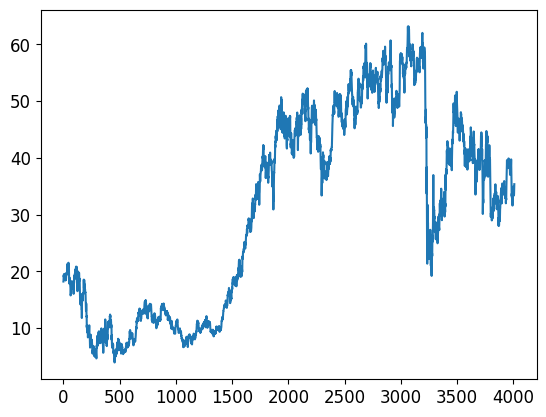

In [9]:
#Plot closing price

plt.plot(Delta_Airlines['Close'])
plt.show()

# Data Cleanup

## RESHAPE the data set!

In [10]:
Delta_Airlines.shape

(4010, 2)

In [11]:
Delta_Airlines.shape[0]/10

401.0

In [12]:
# Re-organize the data set by day
close_price = np.array(Delta_Airlines['Close']).reshape(401,10)
close_price

array([[18.200001, 18.34    , 19.02    , ..., 19.02    , 18.76    ,
        19.09    ],
       [18.98    , 19.049999, 19.549999, ..., 18.83    , 18.379999,
        18.4     ],
       [18.639999, 18.9     , 18.879999, ..., 19.75    , 19.43    ,
        19.49    ],
       ...,
       [39.07    , 39.73    , 38.490002, ..., 33.709999, 32.959999,
        33.139999],
       [33.889999, 32.77    , 32.139999, ..., 34.110001, 34.919998,
        34.389999],
       [33.919998, 33.459999, 33.689999, ..., 33.77    , 34.59    ,
        35.360001]])

In [13]:
# Convert to dataframe

closeprice_df = pd.DataFrame(close_price, columns=np.arange(0,10,1))

closeprice_df

,0,1,2,3,4,5,6,7,8,9
0,18.200001,18.340000,19.020000,19.309999,19.000000,19.480000,19.209999,19.020000,18.760000,19.090000
1,18.980000,19.049999,19.549999,18.840000,18.950001,18.930000,18.480000,18.830000,18.379999,18.400000
2,18.639999,18.900000,18.879999,18.540001,18.870001,19.360001,19.510000,19.750000,19.430000,19.490000
3,19.420000,19.670000,19.700001,19.580000,20.250000,20.520000,20.830000,21.330000,20.650000,20.120001
4,20.430000,20.500000,20.940001,21.190001,21.370001,21.510000,21.400000,21.110001,21.330000,20.780001
...,...,...,...,...,...,...,...,...,...,...
396,39.639999,39.590000,39.439999,39.009998,38.169998,38.599998,39.099998,39.020000,38.279999,38.360001
397,37.099998,37.009998,37.529999,37.360001,37.840000,38.340000,38.509998,38.419998,38.849998,38.459999
398,39.070000,39.730000,38.490002,37.250000,35.680000,35.470001,33.230000,33.709999,32.959999,33.139999
399,33.889999,32.770000,32.139999,31.590000,32.130001,32.470001,33.320000,34.110001,34.919998,34.389999


# Reshape for Standardizing Data

In [14]:
# Let's create a single sequence (i.e., feature) for standardization

closeprice_1feature = np.array(closeprice_df).ravel().reshape(-1,1)

closeprice_1feature.shape

(4010, 1)

In [15]:
closeprice_1feature

array([[18.200001],
       [18.34    ],
       [19.02    ],
       ...,
       [33.77    ],
       [34.59    ],
       [35.360001]])

## Standardize the values

In [16]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

close_std = scaler.fit_transform(closeprice_1feature)

## Reshape the data back to 10 days format

In [17]:
close_reshaped = close_std.reshape(401,10)

close_reshaped.shape

(401, 10)

In [18]:
#Pandas version of the reshaped data

pd.DataFrame(close_reshaped, columns=np.arange(0,10,1))

,0,1,2,3,4,5,6,7,8,9
0,-0.722108,-0.714110,-0.675259,-0.658690,-0.676401,-0.648977,-0.664403,-0.675259,-0.690114,-0.671259
1,-0.677544,-0.673545,-0.644978,-0.685543,-0.679258,-0.680401,-0.706111,-0.686114,-0.711824,-0.710682
2,-0.696970,-0.682115,-0.683258,-0.702683,-0.683829,-0.655833,-0.647263,-0.633551,-0.651834,-0.648406
3,-0.652405,-0.638122,-0.636408,-0.643264,-0.604985,-0.589559,-0.571847,-0.543280,-0.582131,-0.612412
4,-0.594701,-0.590701,-0.565562,-0.551279,-0.540995,-0.532996,-0.539281,-0.555850,-0.543280,-0.574704
...,...,...,...,...,...,...,...,...,...,...
396,0.502834,0.499977,0.491407,0.466840,0.418848,0.443415,0.471982,0.467411,0.425133,0.429703
397,0.357715,0.352573,0.382282,0.372570,0.399994,0.428561,0.438273,0.433131,0.457699,0.435417
398,0.470268,0.507976,0.437131,0.366285,0.276585,0.264587,0.136608,0.164032,0.121182,0.131466
399,0.174316,0.110327,0.074333,0.042909,0.073762,0.093187,0.141750,0.186886,0.233164,0.202883


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of dayly temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are using a random spli because each day as an independent sample.

In [19]:
from sklearn.model_selection import train_test_split

# if we neede to maintain the ordering of the data, we can use the following code to split the data
split_point = int(len(close_reshaped)*0.8)
train, test = close_reshaped[:split_point], close_reshaped[split_point:]

In [20]:
train.shape

(320, 10)

In [21]:
train[:2]

array([[-0.72210823, -0.71410959, -0.67525881, -0.65869015, -0.67640148,
        -0.64897739, -0.6644035 , -0.67525881, -0.69011352, -0.67125946],
       [-0.67754415, -0.67354486, -0.6449781 , -0.68554284, -0.67925809,
        -0.68040082, -0.7061109 , -0.68611417, -0.71182431, -0.71068158]])

In [22]:
test.shape

(81, 10)

In [23]:
test[:2]

array([[1.50038511, 1.42268376, 1.43982376, 1.54780603, 1.60265414,
        1.56208941, 1.54723458, 1.5352366 , 1.58951349, 1.63579169],
       [1.6163663 , 1.60322565, 1.59294156, 1.58094335, 1.57351617,
        1.54437797, 1.33641205, 1.14558607, 1.07131257, 0.9913256 ]])

# Create Input and Target values

The first 23 hours will be input to predict the 24th hour reading (i.e., target)

In [24]:
# The first 9 columns (from 0 to 8) are inputs

train_inputs = train[:,:9]


pd.DataFrame(train_inputs, columns=np.arange(0,9,1))

,0,1,2,3,4,5,6,7,8
0,-0.722108,-0.714110,-0.675259,-0.658690,-0.676401,-0.648977,-0.664403,-0.675259,-0.690114
1,-0.677544,-0.673545,-0.644978,-0.685543,-0.679258,-0.680401,-0.706111,-0.686114,-0.711824
2,-0.696970,-0.682115,-0.683258,-0.702683,-0.683829,-0.655833,-0.647263,-0.633551,-0.651834
3,-0.652405,-0.638122,-0.636408,-0.643264,-0.604985,-0.589559,-0.571847,-0.543280,-0.582131
4,-0.594701,-0.590701,-0.565562,-0.551279,-0.540995,-0.532996,-0.539281,-0.555850,-0.543280
...,...,...,...,...,...,...,...,...,...
315,1.486102,1.499243,1.498671,1.418684,1.398116,1.443823,1.457535,1.520953,1.498671
316,1.480388,1.415828,1.440966,1.430682,1.445537,1.426112,1.410686,1.384976,1.476960
317,1.575801,1.591227,1.584943,1.616938,1.607225,1.634078,1.631221,1.640934,1.613510
318,1.579229,1.611224,1.555233,1.532380,1.529523,1.600369,1.606653,1.622651,1.636934


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [25]:
train_inputs

array([[-0.72210823, -0.71410959, -0.67525881, ..., -0.6644035 ,
        -0.67525881, -0.69011352],
       [-0.67754415, -0.67354486, -0.6449781 , ..., -0.7061109 ,
        -0.68611417, -0.71182431],
       [-0.6969696 , -0.68211483, -0.68325755, ..., -0.64726339,
        -0.63355134, -0.65183407],
       ...,
       [ 1.57580134,  1.59122744,  1.58494293, ...,  1.6312209 ,
         1.64093371,  1.61350968],
       [ 1.57922946,  1.61122429,  1.55523345, ...,  1.60665349,
         1.62265104,  1.63693442],
       [ 1.75862862,  1.77348345,  1.78205336, ...,  1.59808358,
         1.48495929,  1.52209595]])

In [26]:
train_inputs.shape

(320, 9)

In [27]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape

(320, 9, 1)

In [28]:
train_x

array([[[-0.72210823],
        [-0.71410959],
        [-0.67525881],
        ...,
        [-0.6644035 ],
        [-0.67525881],
        [-0.69011352]],

       [[-0.67754415],
        [-0.67354486],
        [-0.6449781 ],
        ...,
        [-0.7061109 ],
        [-0.68611417],
        [-0.71182431]],

       [[-0.6969696 ],
        [-0.68211483],
        [-0.68325755],
        ...,
        [-0.64726339],
        [-0.63355134],
        [-0.65183407]],

       ...,

       [[ 1.57580134],
        [ 1.59122744],
        [ 1.58494293],
        ...,
        [ 1.6312209 ],
        [ 1.64093371],
        [ 1.61350968]],

       [[ 1.57922946],
        [ 1.61122429],
        [ 1.55523345],
        ...,
        [ 1.60665349],
        [ 1.62265104],
        [ 1.63693442]],

       [[ 1.75862862],
        [ 1.77348345],
        [ 1.78205336],
        ...,
        [ 1.59808358],
        [ 1.48495929],
        [ 1.52209595]]])

## Set the target

In [29]:
# The last column (9) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['9'])

,9
0,-0.671259
1,-0.710682
2,-0.648406
3,-0.612412
4,-0.574704
...,...
315,1.512383
316,1.479246
317,1.589513
318,1.748916


## Repeat for TEST

In [30]:
test.shape

(81, 10)

In [31]:
# The first 9 columns (from 0 to 8) are inputs

test_inputs = test[:,:9]

In [32]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(81, 9, 1)

In [33]:
# The last column (9) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['9'])

,9
0,1.635792
1,0.991326
2,0.164032
3,0.049194
4,-0.368452
...,...
76,0.429703
77,0.435417
78,0.131466
79,0.202883


# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [83]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

In [84]:
model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 3ms/step - loss: 1.0759
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.4257
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1194
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0241
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0084
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 13/100
10/10 [=================

### Predictions

In [85]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 4ms/step


In [86]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [87]:
comparison

,actual,predicted
0,59.470001,58.973354
1,48.189999,53.211468
2,33.709999,43.991108
3,31.700001,24.207546
4,24.389999,21.520054
...,...,...
76,38.360001,38.205830
77,38.459999,38.600132
78,33.139999,33.105473
79,34.389999,33.780148


In [88]:
Normal_NN = mean_squared_error(comparison['actual'], comparison['predicted'])
print(Normal_NN)

4.430375768674337


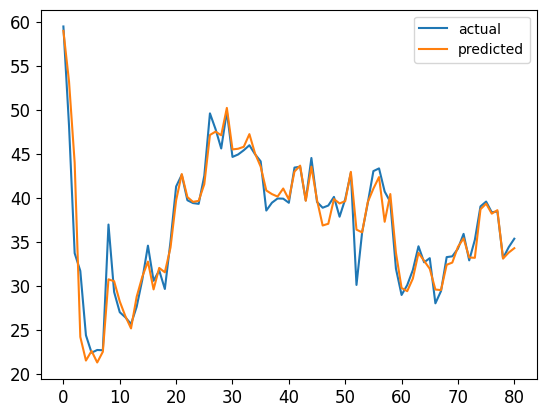

In [89]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

Simplest recurrent neural network

In [98]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=200)

Epoch 1/200
10/10 [==============================] - 1s 10ms/step - loss: 0.8460
Epoch 2/200
10/10 [==============================] - 0s 8ms/step - loss: 0.1561
Epoch 3/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0300
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 6/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 8/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 9/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 10/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 11/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 12/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 13/200
10/10 [================

### Predictions

In [100]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 7ms/step


In [101]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [102]:
comparison

,actual,predicted
0,59.470001,58.362656
1,48.189999,49.118431
2,33.709999,43.623569
3,31.700001,29.118525
4,24.389999,23.166164
...,...,...
76,38.360001,38.407394
77,38.459999,38.625572
78,33.139999,33.237373
79,34.389999,34.272964


In [103]:
Simple_RNN_one_layer =mean_squared_error(comparison['actual'], comparison['predicted'])
Simple_RNN_one_layer

2.5174134271958866

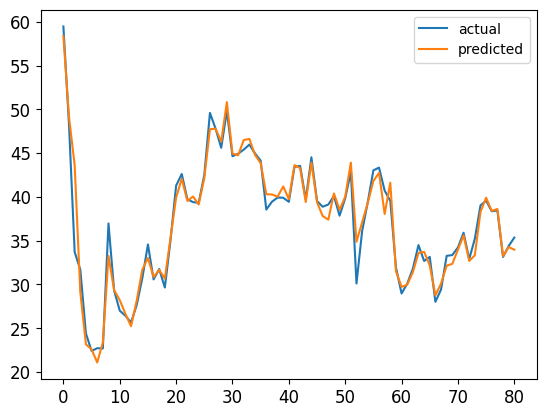

In [104]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training. However, if the output of RNN is sent to a DENSE layer, then a single value should be sent. That's why there is no "return sequences" right before DENSE layers.**

In [127]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(80, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(80, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [128]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
10/10 [==============================] - 2s 22ms/step - loss: 0.2718
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0207
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0052
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0039
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0025
Epoch 10/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 11/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0023
Epoch 12/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 13/100
10/10 [=======

### Predictions

In [129]:
#Predict:
y_pred = model.predict(test_x)


3/3 [==============================] - 1s 8ms/step


In [130]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [131]:
comparison

,actual,predicted
0,59.470001,57.689144
1,48.189999,49.306255
2,33.709999,43.135021
3,31.700001,28.893114
4,24.389999,23.007597
...,...,...
76,38.360001,38.162189
77,38.459999,38.479023
78,33.139999,33.665058
79,34.389999,34.050686


In [132]:
Simple_RNN_with_more_layers =mean_squared_error(comparison['actual'], comparison['predicted'])
Simple_RNN_with_more_layers

2.487277656330221

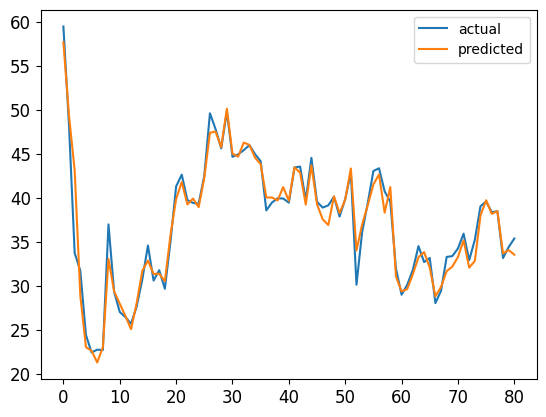

In [133]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [55]:
model = keras.models.Sequential([
    keras.layers.LSTM(70, activation='tanh', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [56]:
np.random.seed(42)
tf.random.set_seed(42)
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
10/10 [==============================] - 4s 14ms/step - loss: 0.2715
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0154
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0225
Epoch 9/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0147
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 11/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 12/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 13/100
10/10 [==============

### Predictions

In [57]:
#Predict:
y_pred = model.predict(test_x)


3/3 [==============================] - 1s 0s/step


In [58]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [59]:
comparison

,actual,predicted
0,59.470001,57.245323
1,48.189999,48.446613
2,33.709999,42.959534
3,31.700001,29.054632
4,24.389999,23.277294
...,...,...
76,38.360001,38.371178
77,38.459999,38.459160
78,33.139999,33.027493
79,34.389999,34.630421


In [60]:
LSTM_with_one_layer =mean_squared_error(comparison['actual'], comparison['predicted'])
LSTM_with_one_layer

2.462738756176627

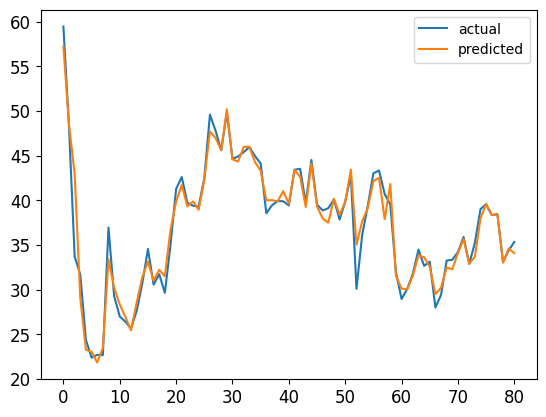

In [61]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [62]:
model = keras.models.Sequential([
    keras.layers.LSTM(70, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(70, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [63]:
np.random.seed(42)
tf.random.set_seed(42)
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
10/10 [==============================] - 7s 17ms/step - loss: 0.3023
Epoch 2/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0222
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0261
Epoch 4/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0231
Epoch 5/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0263
Epoch 6/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0196
Epoch 7/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0173
Epoch 8/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0439
Epoch 9/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0261
Epoch 10/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0130
Epoch 11/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0157
Epoch 12/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0262
Epoch 13/100
10/10 [=====

### Predictions

In [64]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 1s 8ms/step


In [65]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [66]:
comparison

,actual,predicted
0,59.470001,56.880859
1,48.189999,48.397015
2,33.709999,42.445572
3,31.700001,29.075436
4,24.389999,23.611963
...,...,...
76,38.360001,38.023682
77,38.459999,38.244606
78,33.139999,33.246174
79,34.389999,34.395660


In [67]:
LSTM_with_more_layers =mean_squared_error(comparison['actual'], comparison['predicted'])
LSTM_with_more_layers

2.4450792069609446

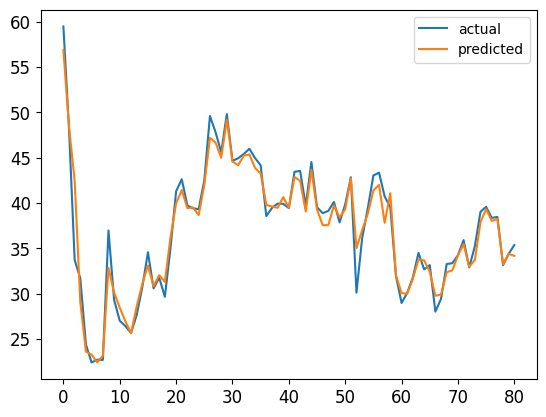

In [68]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [153]:
model = keras.models.Sequential([
    keras.layers.GRU(50, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(50, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [154]:
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Nadam(learning_rate=0.009)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
10/10 [==============================] - 4s 25ms/step - loss: 0.2566
Epoch 2/30
10/10 [==============================] - 0s 20ms/step - loss: 0.0422
Epoch 3/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0202
Epoch 4/30
10/10 [==============================] - 0s 19ms/step - loss: 0.0129
Epoch 5/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0114
Epoch 6/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0045
Epoch 7/30
10/10 [==============================] - 0s 17ms/step - loss: 0.0103
Epoch 8/30
10/10 [==============================] - 0s 17ms/step - loss: 0.0143
Epoch 9/30
10/10 [==============================] - 0s 16ms/step - loss: 0.0226
Epoch 10/30
10/10 [==============================] - 0s 19ms/step - loss: 0.0086
Epoch 11/30
10/10 [==============================] - 0s 17ms/step - loss: 0.0035
Epoch 12/30
10/10 [==============================] - 0s 16ms/step - loss: 0.0102
Epoch 13/30
10/10 [==================

### Predictions

In [155]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 1s 23ms/step


In [156]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [157]:
GRU_with_more_layers =mean_squared_error(comparison['actual'], comparison['predicted'])
GRU_with_more_layers

4.240848439685223

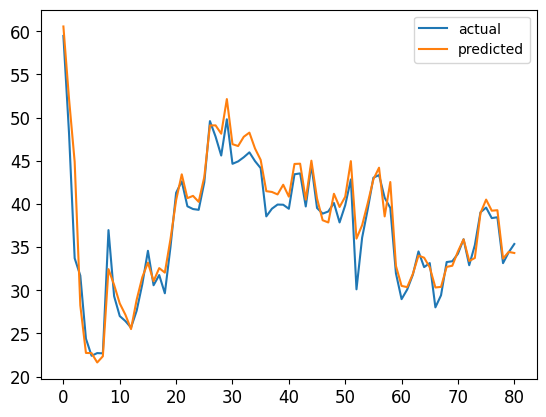

In [158]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [75]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(60, activation='relu', return_sequences=True),
    keras.layers.GRU(60, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [76]:
np.random.seed(42)
tf.random.set_seed(42)
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
10/10 [==============================] - 6s 103ms/step - loss: 0.2705
Epoch 2/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0098
Epoch 3/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0098
Epoch 4/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0079
Epoch 5/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0111
Epoch 6/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0151
Epoch 7/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0110
Epoch 8/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0216
Epoch 9/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0345
Epoch 10/100
10/10 [==============================] - 1s 124ms/step - loss: 0.0078
Epoch 11/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0053
Epoch 12/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0085
Epoch 13/100
10/

### Predictions

In [77]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 1s 14ms/step


In [78]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [79]:
comparison

,actual,predicted
0,59.470001,55.672523
1,48.189999,50.202011
2,33.709999,42.393887
3,31.700001,27.887321
4,24.389999,24.288639
...,...,...
76,38.360001,38.013721
77,38.459999,38.030510
78,33.139999,33.343803
79,34.389999,34.019989


In [80]:
Conv1D =mean_squared_error(comparison['actual'], comparison['predicted'])
Conv1D

3.527252508952622

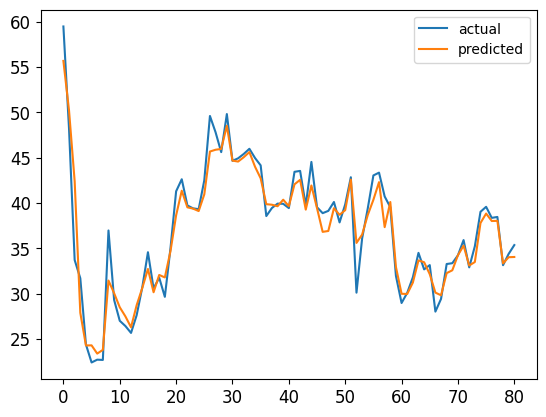

In [81]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

In [159]:
print(f"{'Normal cross-sectional NN:':18}{Normal_NN}")
print(f"{'Simple_RNN_one_layer:':18}{Simple_RNN_one_layer}")
print(f"{'Simple_RNN_with_more_layers:':18}{Simple_RNN_with_more_layers}")
print(f"{'LSTM_with_one_layer:':18}{LSTM_with_one_layer}")
print(f"{'LSTM_with_more_layers:':18}{LSTM_with_more_layers}")
print(f"{'GRU_with_more_layers:':18}{GRU_with_more_layers}")
print(f"{'Conv1D:':18}{Conv1D}")

Normal cross-sectional NN:4.430375768674337
Simple_RNN_one_layer:2.5174134271958866
Simple_RNN_with_more_layers:2.487277656330221
LSTM_with_one_layer:2.462738756176627
LSTM_with_more_layers:2.4450792069609446
GRU_with_more_layers:4.240848439685223
Conv1D:           3.527252508952622


# Analysis
### Based on the mean square errors (MSE) values for each model,

1. The Normal cross-sectional NN has the highest MSE value of 4.43, indicating that it performs the worst among all the models.

2. The Simple_RNN_with_more_layers and the Simple_RNN_one_layer models have an MSE of 2.48 and 2.517 respectively, indicating that they perform better than the Normal cross-sectional NN model.

3. The LSTM_with_more_layers and the LSTM_with_one_layer models have an MSE of 2.44 and 2.46 respectively, indicating that they perform better than the Simple_RNN models.
4. The GRU_with_more_layers model has an MSE of 4.24, indicating that it performs worse than the LSTM and Simple_RNN models, but better than the Normal cross-sectional NN model.
5. The Convolution Layer (1D) model has an MSE of 3.527, indicating that it performs better than the Normal cross-sectional NN model but worse than the LSTM models.

#### Based on the MSE values, it seems like the LSTM_with_more_layers model performs the best among all the models, with the lowest MSE value of 2.44.

This suggests that the sequential nature of the data is important for making accurate predictions.




